In [ ]:
!pip install xgboost

In [ ]:
import csv
import numpy as np
import pandas as pd
import os
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from scipy import stats
import sklearn
from time import time
from sklearn import metrics
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [ ]:
training_impute_median = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/training_impute_median.csv')
training_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/knn imputer/training_impute_knn_norm.csv')
testing_impute_median = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/testing_impute_median.csv')
testing_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/knn imputer/testing_impute_knn_norm.csv')
validation_impute_median = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/validation_impute_median.csv')
validation_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/knn imputer/validation_impute_knn_norm.csv')

In [ ]:
training_impute_median = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/training_impute_median.csv')
training_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/training_impute_median_norm.csv')
testing_impute_median = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/testing_impute_median.csv')
testing_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/testing_impute_median_norm.csv')
validation_impute_median = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/validation_impute_median.csv')
validation_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/validation_impute_median_norm.csv')

In [ ]:
training_impute_median.info

<bound method DataFrame.info of       subject_id  slope_following_9_months  ...  site_onset2  site_onset5
0         553099                 -0.887366  ...            0            0
1           8471                 -0.954460  ...            1            0
2         534458                 -0.521771  ...            0            0
3         225766                 -0.454279  ...            1            0
4         161271                 -0.457694  ...            0            0
...          ...                       ...  ...          ...          ...
1705      445636                 -0.608733  ...            0            0
1706      879802                 -1.102778  ...            0            0
1707      661349                 -0.362341  ...            0            0
1708      355639                 -1.260690  ...            0            0
1709      612378                  0.000000  ...            0            0

[1710 rows x 327 columns]>

In [ ]:
training_impute_median.head()

,subject_id,slope_following_9_months,Age,sex_male,race_white,race_black,race_othergrps,race_asiangrp,study_arm_active,Height_cm,BMI_baseline,race_missing,Delta_first_visit,ALSFRS_Total_beginning,Delta_3_month,ALSFRS_Total_3_month,slope_first_3_months,NeuroDisease,NeuroDisease_DAT,NeuroDisease_Other,NeuroDisease_ALS,NeuroDisease_PARKINSON,NeuroDisease_STROKE,FamilyMember_all,FamilyMember_1st,FamilyMember_2nd,FamilyMember_3rd,OnsetDelta,SymWEAKNESS,SymSpeech,SymCramps,SymFasciculations,SymAtrophy,SymOTHER,SymSwallowing,SymStiffness,SymSENSORY_CHANGES,SymGAIT_CHANGES,SymOnsetDelta,ALTSGPT_ValueAve,...,Blood_Pressure_Systolic_nmeas,Pulse_nmeas,Respiratory_Rate_nmeas,Temperature_nmeas,Weight_kg_nmeas,BMI_nmeas,Blood_Pressure_Diastolic_slope,Blood_Pressure_Systolic_slope,Pulse_slope,Respiratory_Rate_slope,Temperature_slope,Weight_kg_slope,BMI_slope,Subject_used_Riluzole,Riluzole_use_Delta,fvc_liters_ValueMax,fvc_liters_ValueMin,fvc_liters_ValueLast,fvc_liters_ValueMean,fvc_liters_ValueNumber,fvc_liters_valueSum,fvc_liters_DeltaFirst,fvc_liters_DeltaLast,fvc_liters_ValueMeanSquare,fvc_liters_ValueStd,fvc_liters_DeltaSlope,fvc_liters_SlopeMax,fvc_liters_SlopeMin,fvc_liters_SlopeLast,fvc_liters_SlopeMean,fvc_liters_SlopeNumber,fvc_liters_SlopeSum,fvc_liters_SlopeDeltaFirst,fvc_liters_SlopeDeltaLast,fvc_liters_SlopeMeanSquare,fvc_liters_SlopeStd,fvc_liters_SlopeDeltaSlope,site_onset1,site_onset2,site_onset5
0,553099,-0.887366,53.0,1,1,0,0,0,1,165.0,33.535354,0,0.229986,34,1.149929,33,-1.087024,0,0,0,0,0,0,0,0,0,0,-511.0,0,0,0,0,0,0,0,0,0,0,-579.5,43.000000,...,3,2,3,2,2,2,0.571429,0.000000,0.000000,0.000000,0.000000,-0.001258,-0.000479,0,0,4.56,4.18,4.19,4.310000,3,12.93,0,35,18.607366,0.176824,-0.010571,0.000357,-0.054286,0.000357,-0.026964,2,-0.053929,3.5,21.0,0.001474,0.027321,0.003122,1,0,0
1,8471,-0.954460,37.0,1,1,0,0,0,1,169.0,21.357796,0,0.000000,21,2.989815,14,-2.341282,0,0,0,0,0,0,0,0,0,0,-625.5,1,1,0,0,0,0,0,0,0,0,-500.0,25.666667,...,4,4,4,0,4,4,0.087912,0.087912,0.296703,0.021978,0.000000,0.005495,0.001924,1,0,2.87,1.59,1.59,2.055000,4,8.22,0,91,4.463450,0.490332,-0.014066,-0.006061,-0.031786,-0.006333,-0.014727,3,-0.044180,14.0,76.0,0.000362,0.012063,0.000411,0,1,0
2,534458,-0.521771,35.0,1,1,0,0,0,1,170.0,25.155490,0,0.000000,15,2.332713,12,-1.286056,0,0,0,0,0,0,0,0,0,0,-1038.0,0,0,0,0,0,0,0,0,0,0,-579.5,47.000000,...,0,0,5,5,5,5,0.000000,0.000000,0.000000,0.028169,0.001408,-0.032394,-0.010950,0,0,1.86,1.07,1.07,1.635000,4,6.54,0,71,2.781150,0.328519,-0.010986,0.000588,-0.024643,-0.024643,-0.009300,3,-0.027901,8.5,57.0,0.000207,0.010999,-0.000520,1,0,0
3,225766,-0.454279,63.0,0,1,0,0,0,1,161.0,24.690405,0,0.000000,22,2.135582,21,-0.468256,0,0,0,0,0,0,0,0,0,0,-625.5,0,1,0,0,0,0,0,0,0,0,-1441.0,29.000000,...,3,3,3,0,3,3,0.153846,0.307692,-0.338462,0.061538,0.000000,-0.015385,-0.005935,1,0,1.74,1.16,1.16,1.356667,3,4.07,0,65,1.914033,0.271088,-0.008923,-0.000294,-0.018387,-0.000294,-0.009341,2,-0.018681,15.5,48.0,0.000169,0.009046,0.000557,0,1,0
4,161271,-0.457694,61.0,1,1,0,0,0,0,170.0,25.155490,0,0.000000,34,2.989815,33,-0.334469,0,0,0,0,0,0,0,0,0,0,-625.5,1,0,0,0,0,0,0,0,0,0,-364.0,78.000000,...,4,4,4,0,4,4,0.109890,0.219780,0.087912,-0.021978,0.000000,-0.048352,-0.017760,0,0,3.09,2.75,2.75,2.952500,4,11.81,0,91,8.737275,0.141488,-0.003736,-0.000333,-0.005758,-0.005000,-0.003697,3,-0.011091,15.0,77.0,0.000019,0.002398,-0.000075,1,0,0


In [ ]:
training_impute_median_norm.info

<bound method DataFrame.info of       subject_id  slope_following_9_months  ...  site_onset2  site_onset5
0         553099                 -0.887366  ...            0            0
1           8471                 -0.954460  ...            1            0
2         534458                 -0.521771  ...            0            0
3         225766                 -0.454279  ...            1            0
4         161271                 -0.457694  ...            0            0
...          ...                       ...  ...          ...          ...
1705      445636                 -0.608733  ...            0            0
1706      879802                 -1.102778  ...            0            0
1707      661349                 -0.362341  ...            0            0
1708      355639                 -1.260690  ...            0            0
1709      612378                  0.000000  ...            0            0

[1710 rows x 327 columns]>

In [ ]:
training_impute_median_norm.head()

,subject_id,slope_following_9_months,Age,sex_male,race_white,race_black,race_othergrps,race_asiangrp,study_arm_active,Height_cm,BMI_baseline,race_missing,Delta_first_visit,ALSFRS_Total_beginning,Delta_3_month,ALSFRS_Total_3_month,slope_first_3_months,NeuroDisease,NeuroDisease_DAT,NeuroDisease_Other,NeuroDisease_ALS,NeuroDisease_PARKINSON,NeuroDisease_STROKE,FamilyMember_all,FamilyMember_1st,FamilyMember_2nd,FamilyMember_3rd,OnsetDelta,SymWEAKNESS,SymSpeech,SymCramps,SymFasciculations,SymAtrophy,SymOTHER,SymSwallowing,SymStiffness,SymSENSORY_CHANGES,SymGAIT_CHANGES,SymOnsetDelta,ALTSGPT_ValueAve,...,Blood_Pressure_Systolic_nmeas,Pulse_nmeas,Respiratory_Rate_nmeas,Temperature_nmeas,Weight_kg_nmeas,BMI_nmeas,Blood_Pressure_Diastolic_slope,Blood_Pressure_Systolic_slope,Pulse_slope,Respiratory_Rate_slope,Temperature_slope,Weight_kg_slope,BMI_slope,Subject_used_Riluzole,Riluzole_use_Delta,fvc_liters_ValueMax,fvc_liters_ValueMin,fvc_liters_ValueLast,fvc_liters_ValueMean,fvc_liters_ValueNumber,fvc_liters_valueSum,fvc_liters_DeltaFirst,fvc_liters_DeltaLast,fvc_liters_ValueMeanSquare,fvc_liters_ValueStd,fvc_liters_DeltaSlope,fvc_liters_SlopeMax,fvc_liters_SlopeMin,fvc_liters_SlopeLast,fvc_liters_SlopeMean,fvc_liters_SlopeNumber,fvc_liters_SlopeSum,fvc_liters_SlopeDeltaFirst,fvc_liters_SlopeDeltaLast,fvc_liters_SlopeMeanSquare,fvc_liters_SlopeStd,fvc_liters_SlopeDeltaSlope,site_onset1,site_onset2,site_onset5
0,553099,-0.887366,-0.149798,1,1,0,0,0,1,-0.659056,2.377160,0,0.574606,0.684401,-3.109568,0.705804,-0.298912,0,0,0,0,0,0,0,0,0,0,0.448435,0,0,0,0,0,0,0,0,0,0,0.206833,0.536213,...,0.043600,-0.556261,-1.029170,0.182413,-2.115548,-2.102953,2.099861,0.035164,-0.031686,-0.090506,-0.019540,0.161043,0.154757,0,-0.03452,0.913641,0.987665,0.853195,0.905373,-0.829665,0.246411,-0.093458,-2.105375,0.824369,-0.116941,-0.796773,-0.175409,-0.232737,-0.151656,-0.204383,-0.987582,-0.247060,-1.240226,-2.112735,-0.144838,0.752469,1.521037,1,0,0
1,8471,-0.954460,-1.511603,1,1,0,0,0,1,-0.112626,-1.229149,0,-0.486492,-1.582321,1.121954,-2.174685,-1.337812,0,0,0,0,0,0,0,0,0,0,0.145111,1,1,0,0,0,0,0,0,0,0,0.448536,-0.406902,...,0.640053,0.654696,0.098959,-0.750100,0.065692,0.067264,0.313893,0.321160,1.554948,0.300051,-0.019540,0.310065,0.306556,1,-0.03452,-0.565147,-1.235688,-1.305329,-1.078446,0.590483,-0.745238,-0.093458,0.983403,-0.973302,1.777587,-1.170924,-0.187880,-0.189326,-0.164632,-0.180657,0.628461,-0.228245,0.452084,1.115369,-0.145431,0.054459,0.206238,0,1,0
2,534458,-0.521771,-1.681829,1,1,0,0,0,1,0.023982,-0.104485,0,-0.486492,-2.628500,-0.389304,-2.477895,-0.463770,0,0,0,0,0,0,0,0,0,0,-0.947650,0,0,0,0,0,0,0,0,0,0,0.206833,0.753855,...,-1.745757,-1.767219,1.227087,1.581181,1.156312,1.152372,-0.010828,0.035164,-0.031686,0.410068,0.030973,-0.526120,-0.506838,0,-0.03452,-1.448920,-1.682075,-1.737034,-1.447938,0.590483,-1.098948,-0.093458,-0.119732,-1.187120,0.799755,-0.841152,-0.174960,-0.175544,-0.200143,-0.170137,0.628461,-0.196828,-0.434364,0.000206,-0.145514,0.005771,-0.245009,1,0,0
3,225766,-0.454279,0.701329,0,1,0,0,0,1,-1.205486,-0.242217,0,-0.486492,-1.407958,-0.842681,-1.113452,0.213613,0,0,0,0,0,0,0,0,0,0,0.145111,0,1,0,0,0,0,0,0,0,0,-2.412384,-0.225534,...,0.043600,0.049217,-1.029170,-0.750100,-1.024928,-1.017844,0.557434,1.036151,-1.841624,1.003056,-0.019540,-0.150725,-0.189993,1,-0.03452,-1.553923,-1.604816,-1.662316,-1.692800,-0.829665,-1.618985,-0.093458,-0.450673,-1.297330,0.452699,-0.620288,-0.176674,-0.163474,-0.152919,-0.170215,-0.987582,-0.179034,0.693842,-0.528029,-0.145534,-0.083542,0.277112,0,1,0
4,161271,-0.457694,0.531104,1,1,0,0,0,0,0.023982,-0.104485,0,-0.486492,0.684401,1.121954,0.705804,0.324429,0,0,0,0,0,0,0,0,0,0,0.145111,1,0,0,0,0,0,0,0,0,0,0.862017,2.440579,...,0.640053,0.654696,0.098959,-0.750100,0.065692,0.067264,0.395074,0.750155,0.438428,-0.481064,-0.019540,-0.878287,-0.937115,0,-0.03452,-0.372642,-0.239901,-0.342296,-0.288878,0.590483,0.010605,-0.093458,0.983403,-0.430105,-0.330478,-0.064944,-0.176750,-0.139

In [ ]:
x_trn = training_impute_median_norm.drop(columns=['subject_id','slope_following_9_months'])
y_trn = training_impute_median_norm['slope_following_9_months']
x_tst = testing_impute_median_norm.drop(columns=['subject_id','slope_following_9_months'])
y_tst = testing_impute_median_norm['slope_following_9_months']
x_val = validation_impute_median_norm.drop(columns=['subject_id','slope_following_9_months'])
y_val = validation_impute_median_norm['slope_following_9_months']

In [ ]:
data_all = training_impute_median_norm.append(testing_impute_median_norm).append(validation_impute_median_norm)
data_all = data_all.reset_index()
data = training_impute_median_norm.append(testing_impute_median_norm)
X = x_trn.append(x_tst)
y = y_trn.append(y_tst)

# Evaluation Metrics

In [ ]:
def evaluation_metrics(y_test, y_pred, x_trn, n):
  R2 = metrics.r2_score(y_test, y_pred).round(4)
  Adjusted_R2 = (1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-x_trn.shape[1]-1)).round(4)
  MAE = metrics.mean_absolute_error(y_test, y_pred).round(4)
  MSE = metrics.mean_squared_error(y_test, y_pred).round(4)
  RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(4)
  Pearson_Correlation = pearsonr(y_test, y_pred)[0].round(4)

  evaluatin_table = pd.DataFrame.from_dict({"feature": n,
                                            "R^2": R2,
                                            "Adjusted R^2": Adjusted_R2,
                                            "MAE": MAE,
                                            "MSE": MSE,
                                            "RMSE": RMSE,
                                            "Pearson_Correlation": [Pearson_Correlation],
                                            }, 
  )

  return evaluatin_table

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
start_ada = time()
model_ada = AdaBoostRegressor(n_estimators=50,
                              learning_rate=0.1,
                              random_state=2021)
model_ada.fit(x_trn,y_trn)

AdaBoostRegressor(learning_rate=0.1, random_state=2021)

In [ ]:
y_pred = model_ada.predict(x_tst)
runtime_ada = np.round(time()-start_ada,5)
print("runtime", runtime_ada,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst, len(x_trn.columns)))

runtime 3.73366 sec
   feature     R^2  Adjusted R^2     MAE     MSE   RMSE  Pearson_Correlation
0      325  0.0238       -3.0867  0.6131  0.6905  0.831               0.2785


# GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
start_gbr = time()
model_gbr = GradientBoostingRegressor(criterion='squared_error',
                                n_estimators=100,
                                learning_rate=0.1,
                                max_depth=3,
                                random_state=2021)
model_gbr.fit(x_trn, y_trn)

GradientBoostingRegressor(criterion='squared_error', random_state=2021)

In [ ]:
y_pred = model_gbr.predict(x_tst)
runtime_gbr = np.round(time()-start_gbr,5)
print("gbr", runtime_gbr,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst,len(x_trn.columns)))

gbr 6.98597 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325 -1.5565       -9.7021  1.1605  1.8084  1.3448               0.2001


# XGBoost

In [ ]:
from xgboost import XGBRegressor
start_XGB = time()
model_XGB = XGBRegressor(objective ='reg:squarederror',
                         n_estimators=100,
                         learning_rate=0.1,
                         max_depth=3,
                         random_state=2021)
model_XGB.fit(x_trn, y_trn)

XGBRegressor(objective='reg:squarederror', random_state=2021)

In [ ]:
y_pred = model_XGB.predict(x_tst)
runtime_XGB = np.round(time()-start_XGB,5)
print("XGB", runtime_XGB,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst,len(x_trn.columns)))

XGB 1.87646 sec
   feature    R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.087       -2.8219  0.5723  0.6458  0.8036               0.3243


# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# scoring = {'accuracy': make_scorer(accuracy_score)}


param_grid = {
    "loss":["squared_error","absolute_error"],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 5),
    "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["mse", "squared_error"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10, 50, 100]
    }

# param_grid = {
#     'objective' = ['reg:linear',''
#     # 'features': [10,20,50,100,150,200,250,300],
#     'n_estimators': [10,20,50,100,150,200],
#     'learning_rate': [1, 0.5, 0.1, 0.01, 0.001],
#     'max_depth': [3, 4, 5],
# }

model_ada = AdaBoostRegressor()
model_gbr = GradientBoostingRegressor()

grid_search = GridSearchCV(estimator = model_ada, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(x_trn, y_trn)

In [ ]:
df=pd.DataFrame.from_dict(grid_search.cv_results_)

In [ ]:
df

In [ ]:
df.loc[df['mean_test_score'].idxmax()]['params']

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
start_gbr = time()
model_gbr = GradientBoostingRegressor(criterion='squared_error',
                                n_estimators=100,
                                learning_rate=0.1,
                                max_depth=3,
                                random_state=2021,
                                max_features = 'log2',
                                subsample = 0.8)
model_gbr.fit(x_trn, y_trn)

In [ ]:
y_pred = model_gbr.predict(x_tst)
runtime_gbr = np.round(time()-start_gbr,5)
print("gbr", runtime_gbr,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst,len(x_trn.columns)))

In [ ]:
feat_imp = pd.Series(model_gbr.feature_importances_, x_trn.columns).sort_values(ascending=False)[:20]
print(feat_imp)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

# Randomized Search CV

## AdaBoosting

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

ada_params = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 1.0],
    # "min_samples_split": [2, 5, 10],
    # "min_samples_leaf": [1, 2, 4],
    # "max_depth":np.arange(1,20,1),
    # "subsample":np.arange(0.5,1.0,0.1),
    "n_estimators":[10, 50, 100, 500]
}

ada_model = AdaBoostRegressor(random_state=2021)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2021)

ada_clf = RandomizedSearchCV(estimator=ada_model,
                             param_distributions=ada_params,
                             scoring='neg_mean_squared_error', 
                             cv = cv,                   
                             n_iter=5,
                             verbose=1    
)

ada_clf.fit(X,y)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=2021),
                   estimator=AdaBoostRegressor(random_state=2021), n_iter=5,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.2, 1.0],
                                        'n_estimators': [10, 50, 100, 500]},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
y.shape

(2138,)

In [ ]:
print("Best parameters:", ada_clf.best_params_)

Best parameters: {'n_estimators': 100, 'learning_rate': 0.0001}


In [ ]:
# Use tuning parameters
start_ada = time()
ada_model = AdaBoostRegressor(n_estimators=100,learning_rate=0.0001,random_state=2021)
ada_model.fit(x_trn,y_trn)
y_pred_train = ada_model.predict(x_trn)
y_pred_test = ada_model.predict(x_tst)
runtime_ada = np.round(time()-start_ada,5)
print("runtime", runtime_ada,"sec")
print(evaluation_metrics(y_tst, y_pred_test, x_tst,len(x_tst.columns)))

runtime 9.93973 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.0979       -2.7763  0.5584  0.6381  0.7988               0.3572


In [ ]:
start_ada = time()
ada_model.fit(X,y)
y_pred_val = ada_model.predict(x_val)
runtime_ada = np.round(time()-start_ada,5)
print("runtime", runtime_ada,"sec")
print(evaluation_metrics(y_val, y_pred_val, x_val,len(x_val.columns)))

runtime 13.17296 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.0725       -0.3421  0.6491  0.8609  0.9278               0.3023


### Output y

In [ ]:
print(y_pred_train.shape)
print(y_pred_test.shape)
print(y_pred_val.shape)

(1710,)
(428,)
(1053,)


In [ ]:
output_y = pd.DataFrame.from_dict({
    "subject_id": data_all['subject_id'],
    "y_pred": np.append(np.append(y_pred_train,y_pred_test),y_pred_val),
    "y_true": data_all['slope_following_9_months']
})
output_y = output_y.reset_index().drop(columns='index')
output_y

,subject_id,y_pred,y_true
0,553099,-0.874783,-0.887366
1,8471,-1.101303,-0.954460
2,534458,-1.000118,-0.521771
3,225766,-0.798709,-0.454279
4,161271,-0.780235,-0.457694
...,...,...,...
3186,993900,-0.893127,-0.699693
3187,994973,-0.736159,-0.385274
3188,995546,-0.705979,-0.378880
3189,996401,-0.705379,-1.104556


In [ ]:
output_y.to_csv("/content/drive/MyDrive/ML Project/Output/AdaBoosting_output.csv")

### Analysis

In [ ]:
MSE = metrics.mean_squared_error(output_y['y_true'], output_y['y_pred']).round(4)
MSE

0.8102

In [ ]:
Pearson_Correlation = pearsonr(output_y['y_true'], output_y['y_pred'])[0].round(4)
Pearson_Correlation

0.3612

In [ ]:
output_y.describe()

,subject_id,y_pred,y_true
count,3191.000000,3191.000000,3191.000000
mean,499666.061736,-0.831337,-0.857436
std,291684.227591,0.155077,0.944191
min,329.000000,-1.418564,-8.056765
25%,246779.500000,-0.948310,-1.257713
50%,499325.000000,-0.752860,-0.691742
75%,752560.000000,-0.717038,-0.252065
max,999990.000000,0.299879,7.609167


Text(0, 0.5, 'y_true')

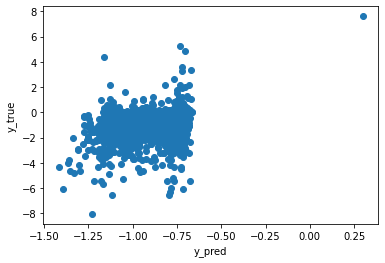

In [ ]:
plt.scatter(output_y['y_pred'], output_y['y_true'])
plt.xlabel("y_pred")
plt.ylabel("y_true")

(-8.840061274650001, 8.39246323565)

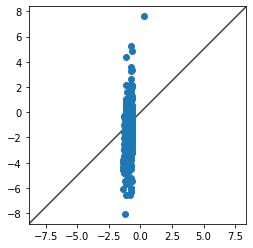

In [ ]:
fig, ax = plt.subplots()
ax.scatter(output_y['y_pred'], output_y['y_true'])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

### get rid of outlier

In [ ]:
z = np.abs(stats.zscore(data_all['slope_following_9_months']))
z

array([0.03170424, 0.1027747 , 0.35556102, ..., 0.50692257, 0.26176806,
       0.35556102])

In [ ]:
threshold = 3
outliers = np.where(z > threshold)[0]
outliers

array([  51,   62,   82,  133,  146,  179,  246,  247,  507,  607,  694,
        722,  734,  752,  755,  821,  855,  874,  880,  924,  985, 1046,
       1088, 1187, 1321, 1324, 1398, 1406, 1444, 1541, 1568, 1592, 1609,
       1622, 1700, 1736, 1829, 1868, 1879, 1936, 2205, 2258, 2411, 2433,
       2482, 2557, 2572, 2592, 2677, 2711, 2724, 2725, 2749, 2756, 2809,
       3013, 3050])

In [ ]:
len(outliers)

57

In [ ]:
output_y.iloc[outliers.tolist(),:]

,subject_id,y_pred,y_true
51,303218,-1.391971,-6.087333
62,380751,-1.126129,2.174048
82,330665,-0.782798,-3.804583
133,770063,-0.925577,-3.726939
146,525197,-0.764573,-5.435119
179,151434,-1.332152,-4.782905
246,230778,-0.798709,-3.726939
247,295093,-1.365959,-3.985754
507,584290,-0.726057,-4.348095
607,340898,-0.734635,5.247701


In [ ]:
output_no_outliers = output_y.drop(index=outliers)
output_no_outliers

,subject_id,y_pred,y_true
0,553099,-0.874783,-0.887366
1,8471,-1.101303,-0.954460
2,534458,-1.000118,-0.521771
3,225766,-0.798709,-0.454279
4,161271,-0.780235,-0.457694
...,...,...,...
3186,993900,-0.893127,-0.699693
3187,994973,-0.736159,-0.385274
3188,995546,-0.705979,-0.378880
3189,996401,-0.705379,-1.104556


In [ ]:
MSE = metrics.mean_squared_error(output_no_outliers['y_true'], output_no_outliers['y_pred']).round(4)
MSE

0.5286

In [ ]:
Pearson_Correlation = pearsonr(output_no_outliers['y_true'], output_no_outliers['y_pred'])[0].round(4)
Pearson_Correlation

0.3467

## Gradient Boosting

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

GB_params = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 1.0],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_depth":np.arange(1,20,1),
    "subsample":np.arange(0.5,1.0,0.1),
    "n_estimators":[10, 50, 100, 500]
}

GB_model = GradientBoostingRegressor(random_state=2021)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2021)

GB_clf = RandomizedSearchCV(estimator=GB_model,
                         param_distributions=GB_params,
                         scoring='neg_mean_squared_error',
                         cv = cv,
                         n_iter=5,
                         verbose=1    
)

GB_clf.fit(X,y)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=2021),
                   estimator=GradientBoostingRegressor(random_state=2021),
                   n_iter=5,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.2, 1.0],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 500],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print("Best parameters:", GB_clf.best_params_)

Best parameters: {'subsample': 0.5, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 1, 'learning_rate': 0.1}


In [ ]:
GB_model = GradientBoostingRegressor(
    subsample = 0.5,
    n_estimators = 100,
    min_samples_leaf = 2,
    min_samples_split = 10,
    max_depth = 1,
    learning_rate = 0.1
)

In [ ]:
start_GB = time()
GB_model.fit(x_trn,y_trn)
y_pred_train = GB_model.predict(x_trn)
y_pred_test = GB_model.predict(x_tst)
runtime_GB = np.round(time()-start_GB,5)
print("GB", runtime_GB,"sec")
print(evaluation_metrics(y_tst, y_pred_test, x_tst,len(x_tst.columns)))

GB 1.71334 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.1084       -2.7323  0.5472  0.6307  0.7941                0.335


In [ ]:
start_GB = time()
GB_model.fit(X,y)
y_pred_val = GB_model.predict(x_val)
runtime_GB = np.round(time()-start_GB,5)
print("XGB", runtime_GB,"sec")
print(evaluation_metrics(y_val, y_pred_val, x_val,len(x_val.columns)))

XGB 2.29721 sec
   feature     R^2  Adjusted R^2     MAE     MSE   RMSE  Pearson_Correlation
0      325  0.1233       -0.2686  0.6287  0.8137  0.902                0.354


### Output y

In [ ]:
output_y = pd.DataFrame.from_dict({
    "subject_id": data_all['subject_id'],
    "y_pred": np.append(np.append(y_pred_train,y_pred_test),y_pred_val),
    "y_true": data_all['slope_following_9_months']
})
output_y = output_y.reset_index().drop(columns='index')
output_y

,subject_id,y_pred,y_true
0,553099,-0.928121,-0.887366
1,8471,-1.160303,-0.954460
2,534458,-0.983918,-0.521771
3,225766,-0.865855,-0.454279
4,161271,-0.949709,-0.457694
...,...,...,...
3186,993900,-0.905060,-0.699693
3187,994973,-0.783554,-0.385274
3188,995546,-0.693518,-0.378880
3189,996401,-0.709113,-1.104556


In [ ]:
output_y.to_csv("/content/drive/MyDrive/ML Project/Output/GradientBoosting_output.csv")

### Analysis

In [ ]:
MSE = metrics.mean_squared_error(output_y['y_true'], output_y['y_pred']).round(4)
MSE

0.7796

In [ ]:
Pearson_Correlation = pearsonr(output_y['y_true'], output_y['y_pred'])[0].round(4)
Pearson_Correlation

0.399

In [ ]:
output_y.describe()

,subject_id,y_pred,y_true
count,3191.000000,3191.000000,3191.000000
mean,499666.061736,-0.857496,-0.857436
std,291684.227591,0.202848,0.944191
min,329.000000,-2.627039,-8.056765
25%,246779.500000,-0.965993,-1.257713
50%,499325.000000,-0.829976,-0.691742
75%,752560.000000,-0.717258,-0.252065
max,999990.000000,-0.220759,7.609167


Text(0, 0.5, 'y_true')

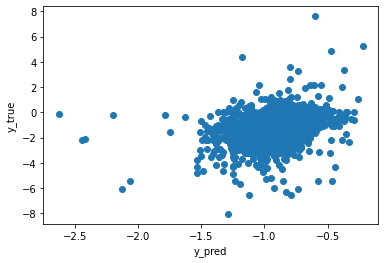

In [ ]:
plt.scatter(output_y['y_pred'], output_y['y_true'])
plt.xlabel("y_pred")
plt.ylabel("y_true")

(-8.840061274650001, 8.39246323565)

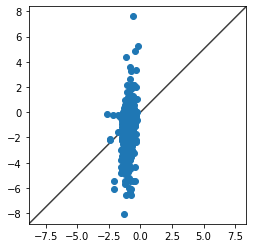

In [ ]:
fig, ax = plt.subplots()
ax.scatter(output_y['y_pred'], output_y['y_true'])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

### get rid of outlier

In [ ]:
z = np.abs(stats.zscore(data_all['slope_following_9_months']))
z

array([0.03170424, 0.1027747 , 0.35556102, ..., 0.50692257, 0.26176806,
       0.35556102])

In [ ]:
threshold = 3
outliers = np.where(z > threshold)[0]
outliers

array([  51,   62,   82,  133,  146,  179,  246,  247,  507,  607,  694,
        722,  734,  752,  755,  821,  855,  874,  880,  924,  985, 1046,
       1088, 1187, 1321, 1324, 1398, 1406, 1444, 1541, 1568, 1592, 1609,
       1622, 1700, 1736, 1829, 1868, 1879, 1936, 2205, 2258, 2411, 2433,
       2482, 2557, 2572, 2592, 2677, 2711, 2724, 2725, 2749, 2756, 2809,
       3013, 3050])

In [ ]:
len(outliers)

57

In [ ]:
output_y.iloc[outliers.tolist(),:]

,subject_id,y_pred,y_true
51,303218,-2.129082,-6.087333
62,380751,-1.044534,2.174048
82,330665,-0.831256,-3.804583
133,770063,-1.014824,-3.726939
146,525197,-0.855396,-5.435119
179,151434,-1.529785,-4.782905
246,230778,-0.841870,-3.726939
247,295093,-1.132806,-3.985754
507,584290,-0.443120,-4.348095
607,340898,-0.220759,5.247701


In [ ]:
output_no_outliers = output_y.drop(index=outliers)
output_no_outliers

,subject_id,y_pred,y_true
0,553099,-0.928121,-0.887366
1,8471,-1.160303,-0.954460
2,534458,-0.983918,-0.521771
3,225766,-0.865855,-0.454279
4,161271,-0.949709,-0.457694
...,...,...,...
3186,993900,-0.905060,-0.699693
3187,994973,-0.783554,-0.385274
3188,995546,-0.693518,-0.378880
3189,996401,-0.709113,-1.104556


In [ ]:
MSE = metrics.mean_squared_error(output_no_outliers['y_true'], output_no_outliers['y_pred']).round(4)
MSE

0.5061

In [ ]:
Pearson_Correlation = pearsonr(output_no_outliers['y_true'], output_no_outliers['y_pred'])[0].round(4)
Pearson_Correlation

0.3967

## XGBoost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

XGB_params = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 1.0],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_depth":np.arange(1,20,1),
    "subsample":np.arange(0.5,1.0,0.1),
    "n_estimators":[10, 50, 100, 500]
}

XGB_model = XGBRegressor(objective='reg:squarederror',random_state=2021)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2021)

XGB_clf = RandomizedSearchCV(estimator=XGB_model,
                         param_distributions=XGB_params,
                         scoring='neg_mean_squared_error',
                         cv = cv,
                         n_iter=5,
                         verbose=1    
)

XGB_clf.fit(X,y)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=2021),
                   estimator=XGBRegressor(objective='reg:squarederror',
                                          random_state=2021),
                   n_iter=5,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.2, 1.0],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 500],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print("Best parameters:", XGB_clf.best_params_)

Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 11, 'learning_rate': 1.0}


In [ ]:
XGB_model = GradientBoostingRegressor(
    subsample = 0.9,
    n_estimators = 100,
    min_samples_leaf = 1,
    min_samples_split = 2,
    max_depth = 11,
    learning_rate = 1.0
)

In [ ]:
start_XGB = time()
XGB_model.fit(x_trn,y_trn)
y_pred_train = XGB_model.predict(x_trn)
y_pred_test = XGB_model.predict(x_tst)
runtime_XGB = np.round(time()-start_XGB,5)
print("XGB", runtime_XGB,"sec")
print(evaluation_metrics(y_tst, y_pred_test, x_tst,len(x_tst.columns)))

XGB 22.49906 sec
   feature     R^2  Adjusted R^2     MAE   MSE    RMSE  Pearson_Correlation
0      325 -3.7924      -19.0625  1.3131  3.39  1.8412               0.1474


In [ ]:
start_XGB = time()
XGB_model.fit(X,y)
y_pred_val = XGB_model.predict(x_val)
runtime_XGB = np.round(time()-start_XGB,5)
print("XGB", runtime_XGB,"sec")
print(evaluation_metrics(y_val, y_pred_val, x_val,len(x_val.columns)))

XGB 31.14231 sec
   feature     R^2  Adjusted R^2     MAE    MSE    RMSE  Pearson_Correlation
0      325 -1.3465       -2.3955  1.0552  2.178  1.4758               0.1308


### Output y

In [ ]:
output_y = pd.DataFrame.from_dict({
    "subject_id": data_all['subject_id'],
    "y_pred": np.append(np.append(y_pred_train,y_pred_test),y_pred_val),
    "y_true": data_all['slope_following_9_months']
})
output_y = output_y.reset_index().drop(columns='index')
output_y

,subject_id,y_pred,y_true
0,553099,-0.879663,-0.887366
1,8471,-0.937529,-0.954460
2,534458,-0.829810,-0.521771
3,225766,-0.814011,-0.454279
4,161271,-0.834821,-0.457694
...,...,...,...
3186,993900,-0.788228,-0.699693
3187,994973,-0.819277,-0.385274
3188,995546,-0.826886,-0.378880
3189,996401,-0.715035,-1.104556


In [ ]:
output_y.to_csv("/content/drive/MyDrive/ML Project/Output/XGBoost_output.csv")

### Analysis

In [ ]:
MSE = metrics.mean_squared_error(output_y['y_true'], output_y['y_pred']).round(4)
MSE

0.7198

In [ ]:
Pearson_Correlation = pearsonr(output_y['y_true'], output_y['y_pred'])[0].round(4)
Pearson_Correlation

0.6824

In [ ]:
output_y.describe()

,subject_id,y_pred,y_true
count,3191.000000,3191.000000,3191.000000
mean,499666.061736,-0.863036,-0.857436
std,291684.227591,0.150693,0.944191
min,329.000000,-1.661942,-8.056765
25%,246779.500000,-0.941325,-1.257713
50%,499325.000000,-0.842414,-0.691742
75%,752560.000000,-0.759743,-0.252065
max,999990.000000,-0.076561,7.609167


Text(0, 0.5, 'y_true')

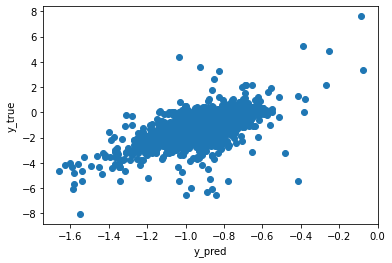

In [ ]:
plt.scatter(output_y['y_pred'], output_y['y_true'])
plt.xlabel("y_pred")
plt.ylabel("y_true")

(-8.840061274650001, 8.39246323565)

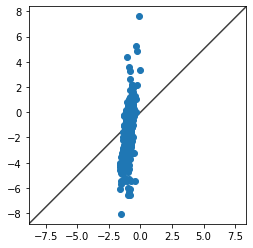

In [ ]:
fig, ax = plt.subplots()
ax.scatter(output_y['y_pred'], output_y['y_true'])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

### get rid of outlier

In [ ]:
z = np.abs(stats.zscore(data_all['slope_following_9_months']))
z

array([0.03170424, 0.1027747 , 0.35556102, ..., 0.50692257, 0.26176806,
       0.35556102])

In [ ]:
threshold = 3
outliers = np.where(z > threshold)[0]
outliers

array([  51,   62,   82,  133,  146,  179,  246,  247,  507,  607,  694,
        722,  734,  752,  755,  821,  855,  874,  880,  924,  985, 1046,
       1088, 1187, 1321, 1324, 1398, 1406, 1444, 1541, 1568, 1592, 1609,
       1622, 1700, 1736, 1829, 1868, 1879, 1936, 2205, 2258, 2411, 2433,
       2482, 2557, 2572, 2592, 2677, 2711, 2724, 2725, 2749, 2756, 2809,
       3013, 3050])

In [ ]:
len(outliers)

57

In [ ]:
output_y.iloc[outliers.tolist(),:]

,subject_id,y_pred,y_true
51,303218,-1.588642,-6.087333
62,380751,-0.652620,2.174048
82,330665,-1.233195,-3.804583
133,770063,-1.318655,-3.726939
146,525197,-1.341684,-5.435119
179,151434,-1.584029,-4.782905
246,230778,-1.255592,-3.726939
247,295093,-1.600487,-3.985754
507,584290,-1.039843,-4.348095
607,340898,-0.386209,5.247701


In [ ]:
output_no_outliers = output_y.drop(index=outliers)
output_no_outliers

,subject_id,y_pred,y_true
0,553099,-0.879663,-0.887366
1,8471,-0.937529,-0.954460
2,534458,-0.829810,-0.521771
3,225766,-0.814011,-0.454279
4,161271,-0.834821,-0.457694
...,...,...,...
3186,993900,-0.788228,-0.699693
3187,994973,-0.819277,-0.385274
3188,995546,-0.826886,-0.378880
3189,996401,-0.715035,-1.104556


In [ ]:
MSE = metrics.mean_squared_error(output_no_outliers['y_true'], output_no_outliers['y_pred']).round(4)
MSE

0.4628

In [ ]:
Pearson_Correlation = pearsonr(output_no_outliers['y_true'], output_no_outliers['y_pred'])[0].round(4)
Pearson_Correlation

0.6794

# Feature Importance

slope_first_3_months              0.066081
SymOnsetDelta                     0.043726
OnsetDelta                        0.035582
fvc_liters_DeltaSlope             0.023593
fvc_liters_valueSum               0.021266
BMI_slope                         0.019207
Basophils_ValueMax                0.018492
ALSFRS_Total_3_month              0.015050
Temperature_max                   0.012800
Weight_kg_slope                   0.012033
fvc_liters_ValueLast              0.011472
Bicarbonate_ValueMax              0.010648
fvc_liters_SlopeLast              0.010120
Temperature_sd                    0.009895
AbsoluteBasophilCount_ValueSd     0.009456
fvc_liters_ValueStd               0.008960
Basophils_ValueSd                 0.008839
Respiratory_Rate_mean             0.008068
Chloride_ValueAve                 0.008049
fvc_liters_ValueMin               0.007951
Bicarbonate_ValueMin              0.007941
Sodium_ValueSd                    0.007750
fvc_liters_SlopeSum               0.007645
WhiteBloodC

Text(0, 0.5, 'Feature Importance Score')

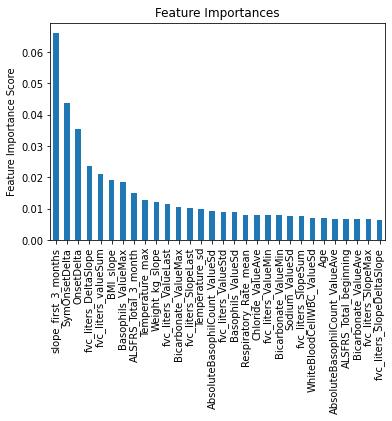

In [ ]:
feat_imp = pd.Series(XGB_model.feature_importances_, x_trn.columns).sort_values(ascending=False)[:30]
print(feat_imp)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
df_feat_imp = pd.DataFrame(feat_imp)
df_feat_imp

,0
slope_first_3_months,0.066081
SymOnsetDelta,0.043726
OnsetDelta,0.035582
fvc_liters_DeltaSlope,0.023593
fvc_liters_valueSum,0.021266
BMI_slope,0.019207
Basophils_ValueMax,0.018492
ALSFRS_Total_3_month,0.015050
Temperature_max,0.012800
Weight_kg_slope,0.012033


In [ ]:
df_feat_imp.to_csv("/content/drive/MyDrive/ML Project/top features/XGB_top_features.csv")

# Lasso features

In [ ]:
top_feature_lasso = ['SymOnsetDelta', 'fvc_liters_ValueLast', 'slope_first_3_months',
       'OnsetDelta', 'BMI_slope', 'Basophils_ValueSd',
       'AbsoluteBasophilCount_ValueMax', 'Respiratory_Rate_sd',
       'Chloride_ValueMin', 'fvc_liters_ValueStd', 'Neutrophils_TestNum',
       'Chloride_ValueSd', 'Potassium_ValueMin', 'Pulse_sd',
       'Basophils_ValueMax', 'Bicarbonate_ValueAve', 'BMI_last',
       'Phosphorus_ValueMin', 'Temperature_sd', 'Lymphocytes_ValueAve',
       'Temperature_max', 'Glucose_ValueMin', 'Temperature_nmeas',
       'Phosphorus_ValueAve', 'Vital_Signs_Delta_last', 'Pulse_min',
       'Respiratory_Rate_min', 'WhiteBloodCellWBC_ValueAve',
       'ALSFRS_Total_3_month', 'BilirubinTotal_ValueMin']

In [ ]:
x_trn = x_trn[top_feature_lasso]
x_tst = x_tst[top_feature_lasso]

In [ ]:
start_XGB = time()
model_XGB = XGBRegressor(objective ='reg:squarederror',
                         n_estimators=100,
                         learning_rate=0.1,
                         max_depth=3,
                         random_state=2021)
model_XGB.fit(x_trn, y_trn)

XGBRegressor(objective='reg:squarederror', random_state=2021)

In [ ]:
y_pred = model_XGB.predict(x_tst)
runtime_XGB = np.round(time()-start_XGB,5)
print("XGB", runtime_XGB,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst,len(x_trn.columns)))

XGB 0.26741 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0       30  0.1282        0.0623  0.5527  0.6167  0.7853               0.3737


Temperature_max                   0.073767
AbsoluteBasophilCount_ValueMax    0.070137
slope_first_3_months              0.068595
Basophils_ValueSd                 0.066805
Basophils_ValueMax                0.051742
SymOnsetDelta                     0.051260
Bicarbonate_ValueAve              0.046752
BMI_slope                         0.038476
Neutrophils_TestNum               0.036160
fvc_liters_ValueLast              0.035800
Phosphorus_ValueMin               0.034401
WhiteBloodCellWBC_ValueAve        0.033262
OnsetDelta                        0.031568
Glucose_ValueMin                  0.031315
fvc_liters_ValueStd               0.031119
Phosphorus_ValueAve               0.029845
Temperature_nmeas                 0.028553
ALSFRS_Total_3_month              0.027742
Temperature_sd                    0.026157
BMI_last                          0.023324
dtype: float32


Text(0, 0.5, 'Feature Importance Score')

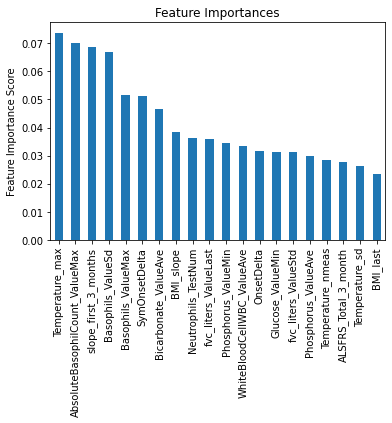

In [ ]:
feat_imp = pd.Series(model_XGB.feature_importances_, x_trn.columns).sort_values(ascending=False)[:20]
print(feat_imp)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')